# Time series forecasting with Tensorflow : BitPredict

Lets write some tensorflow code to predict the price of bitcoin based on historical price of Bitcoin

Note: This is not financial advice



## Get data

We're going to be using historical price data of bitcoin to try and predict the future price of bitcoin. we are downloading data from here..

https://www.coindesk.com/price/bitcoin

In [1]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
!python -m wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv


Saved under BTC_USD_2013-10-01_2021-05-18-CoinDesk (1).csv


## Importing Time series data with pandas

In [2]:
# Import with pandas 
import pandas as pd

# Lets read in our bitcoin data and parse the dates

df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col = ["Date"])# parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
# How many samples do we have?
len(df)

2787

In [5]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


We've collected the historical price of bitcoin for the past -8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can be thosands to tens of thousands to millions)

A smaller number of samples is something you will often run into with time series data problem.

> **Note**: The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin Data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

In [6]:
8*365

2920

In [7]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)":"Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


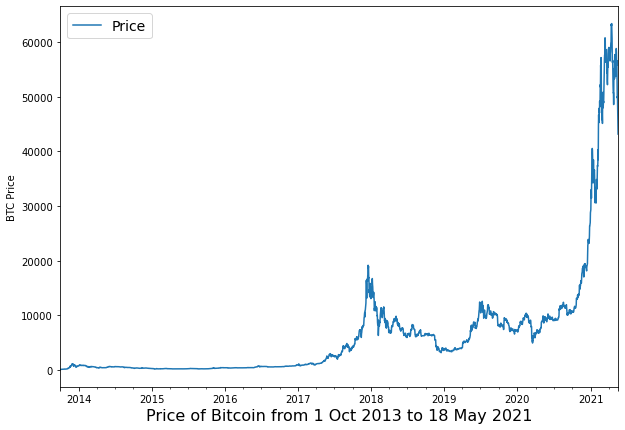

In [8]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel('BTC Price')
plt.xlabel('Price of Bitcoin from 1 Oct 2013 to 18 May 2021',fontsize=16)
plt.legend(fontsize=14)

## Importing time series data with Python's CSV module

In [9]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps=[]
btc_price=[]
with open("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
  next(csv_reader)# skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
    btc_price.append(float(line[2])) # get the closing price as float


# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

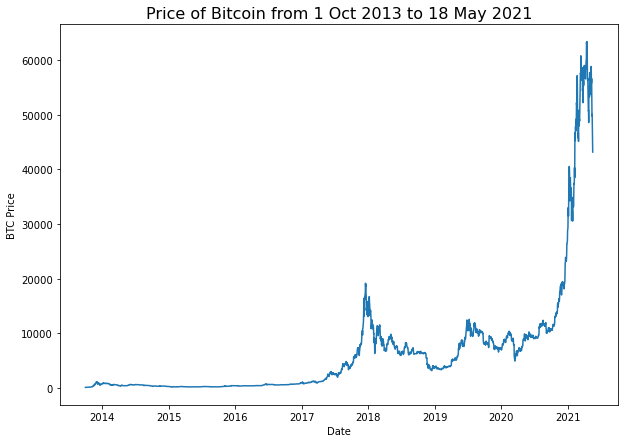

In [10]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price");

## Format Data Part 1: Creatining train and test sets for time series data

### Create train & test sets for time series (the wrong way)

In [11]:
bitcoin_prices[:5]

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [12]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10],prices[:10]


(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [13]:
# Wrong way to make train/test sets for time series

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape,X_test.shape,y_train.shape,y_test.shape,

((2229,), (558,), (2229,), (558,))

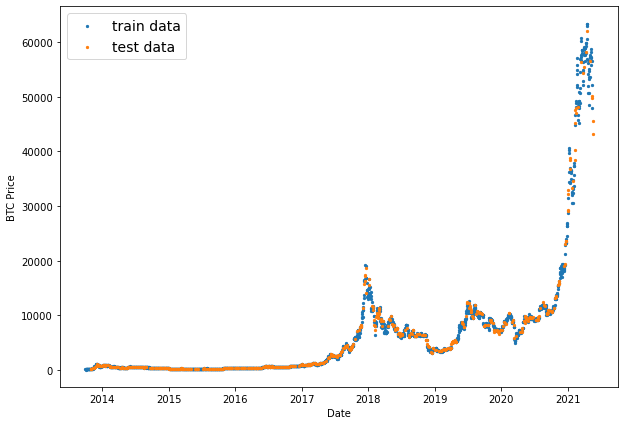

In [14]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='train data')
plt.scatter(X_test,y_test, s=5, label='test data')
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create train & test sets for time series (the right way)

In [15]:
# Create train and test splits the right way for time series data
split_size = int(0.8*len(prices))  # 80% train, 20% test  - you can change these values

# Create train data splits (everything before the split)
X_train , y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

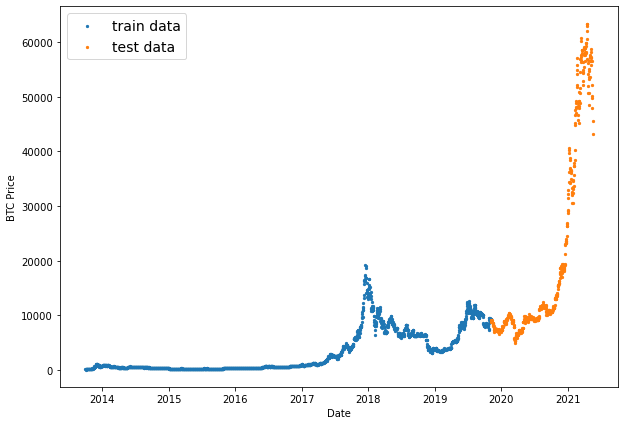

In [16]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='train data')
plt.scatter(X_test,y_test, s=5, label='test data')
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create a plotting function

Typing plotting code is Tedious, Lets functionize it

In [17]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):

# format='.' means scatter plot

  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values, default None
  """

  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True) # The lines for the graph


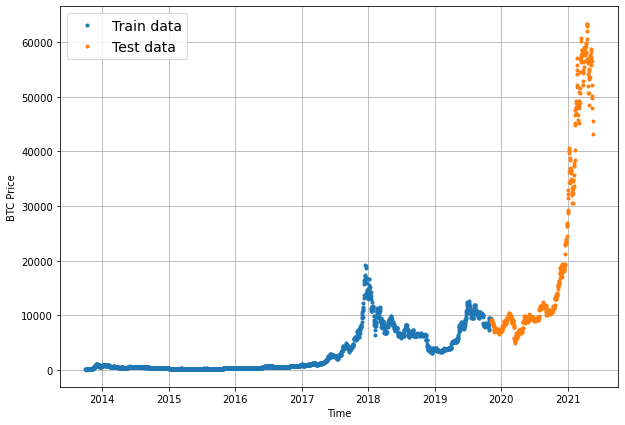

In [18]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

We've got some Bitcoin historical data, to model it, lets run a series of modelling experiments and see which model performs best

Before we discuss what modelling experiments we're going to run, there are two terms you should be familiar with, **horizon** and **window**. 
  * **horizon** = number of timesteps to predict into future
  * **window** = number of timesteps from past used to predict **horizon**

For example, if we wanted to predict the price of Bitcoin for tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and the window would be 7.

Now, how about those modelling experiments?

| Model Number | Model Type | Horizon size | Window size | Extra data |
| ----- | ----- | ----- | ----- | ----- |
| 0 | Naïve model (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA | 
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | Same as 1 (but with multivariate data) | 1 | 7 | Block reward size |
| 7 | [N-BEATs Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA | 
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA| 
| 10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA |


## Model 0: Naïve forecast (baseline)


The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$ 


In English: 
> The prediction at timestep `t` (y-hat) is equal to the value at timestep `t-1` (the previous timestep).



In [19]:
y_test[:10]

array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
       8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
       8500.64355816, 8469.2608989 ])

In [20]:
# Create a naïve forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [21]:
y_test[-10:]

array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
       52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
       45604.61575361, 43144.47129086])

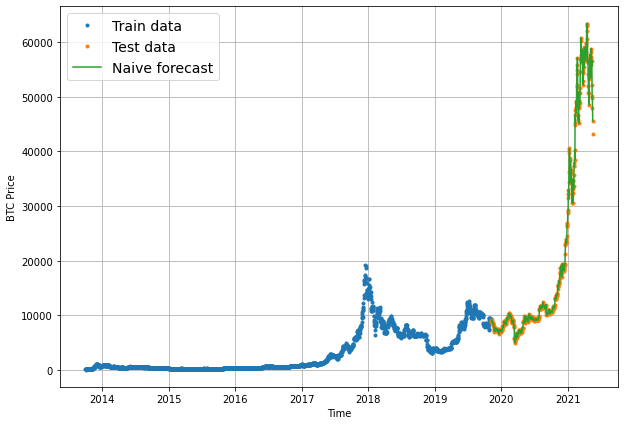

In [22]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values = naive_forecast, format="-", label="Naive forecast");

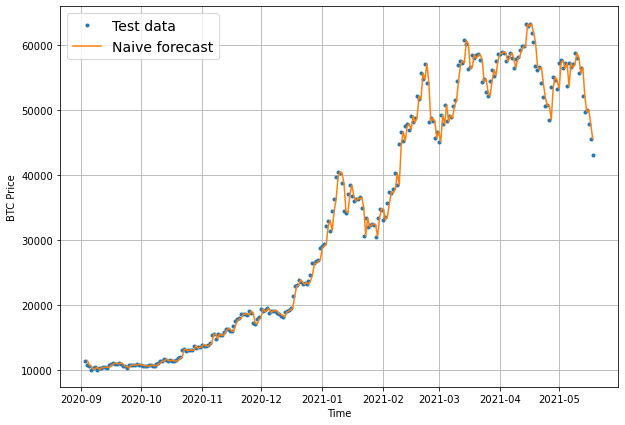

In [23]:
# Zooming in
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing?
 
We're predicting a number, so that means we have a form of a regression problem.

Because we are working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean squared error
* MAPE/sMAPE (Symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all the above metrics, **lower is better** , for example, an MAE of 0 that is better than an MAE of 100

The main thing we're evaluating here is: **how do our models forecast (y_pred) compare against the actual values (y_true or groundtruth values)?**

**Resources** : For a deeper dive on various kinds of time series forcasting methods see  [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html)

In [24]:
import tensorflow as tf

In [25]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16

def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season



In [26]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182626

In [27]:
# Create a function to take  in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

Thats one good looking evaluation function

Let's see now if it works

In [28]:
naive_results = evaluate_preds(y_true = y_test[1:],
                               y_pred = naive_forecast)

naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.9995699}

In [29]:
naive_forecast[-10:]

array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
       56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
       47885.62525472, 45604.61575361])

In [30]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737226

In [31]:
tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>,
 <tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>)

## Other kinds of time series forecasting models which can be used for baselines and actual forecasts

In this notebook , we're focused on tensorflow and deep learning models.

However, there are plenty of other styles of time series forcasting models you may want to experment with

| **Model/Library Name** | **Resource** |
| ----- | ----- |
| Moving average | https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) | https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) | https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) | https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) | https://github.com/facebookresearch/Kats | 
| LinkedIn Greykite (flexible, intuitive and fast forecasts) | https://github.com/linkedin/greykite |

## Format Data Part 2: Windowing dataset

Why do we window?

We window our time series dataset to turn our data into supervised learning problem.


```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```


In [32]:
len(y_train)

2229

In [33]:
# What we want to do with our bitcoin data
print(f"We want to use:{btc_price[:7]} to predict this: {btc_price[7]}")


We want to use:[123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [34]:
# Lets setup global variables for window and horizon size
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [35]:
# Create function to label windowed data'
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6, 7] -> Output: ([1, 2, 3, 4, 5, 6], [7])
  """

  return x[:, :-horizon], x[:, -horizon:]



In [36]:
# Test out the window labelling function

test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8) + 1, axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [37]:
tf.range(8)+1

<tf.Tensor: shape=(8,), dtype=int32, numpy=array([1, 2, 3, 4, 5, 6, 7, 8])>

In [38]:
tf.expand_dims(tf.range(8) + 1, axis=0)

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7, 8]])>

we've got a way to window our labelled data

However , this only works on a small scale

We need a way to do the above across our entire time series.

We could do this with python for loops, however, for large time series, that would be quite low.

To speed things up, we'll keverage Numpy's array indexing -
https://numpy.org/doc/stable/reference/arrays.indexing.html

Our Function will:
1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses NumPy indexing to create a 2D of multiple window steps, for example: 
```
[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [2, 3, 4, 5, 6, 7, 8, 9]]
```
3. Uses the 2D array of multuple window steps to index on a target series
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

> 📖 **Resource:** The function created below has been adapted from Syafiq Kamarul Azman's article [*Fast and Robust Sliding Window Vectorization with NumPy*](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5).


In [39]:
# Create function to view NumPy arrays as windows 

def make_windows(x, window_size = WINDOW_SIZE, horizon = HORIZON):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon),axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)),axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes] # Getting the values of the indexes
  # print(windowed_array)

  # 4. Get the labelled windows
  windows,labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels



In [40]:
len(prices)

2787

In [41]:
a= [[0,1,2,3,4,5,6,7]]

In [42]:
np.expand_dims(np.arange(len(prices) - (7 + 1 - 1)), axis=0).T # window_size + horizon - 1 is done to avoid crossing the 2787 limit


array([[   0],
       [   1],
       [   2],
       ...,
       [2777],
       [2778],
       [2779]])

In [43]:
# also this works

np.expand_dims(np.arange(len(prices) - (7 + 1 - 1)), axis=1)

array([[   0],
       [   1],
       [   2],
       ...,
       [2777],
       [2778],
       [2779]])

In [44]:
a + np.expand_dims(np.arange(len(prices) - (7 + 1 - 1)), axis=0).T

array([[   0,    1,    2, ...,    5,    6,    7],
       [   1,    2,    3, ...,    6,    7,    8],
       [   2,    3,    4, ...,    7,    8,    9],
       ...,
       [2777, 2778, 2779, ..., 2782, 2783, 2784],
       [2778, 2779, 2780, ..., 2783, 2784, 2785],
       [2779, 2780, 2781, ..., 2784, 2785, 2786]])

In [45]:
del a

In [46]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [47]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [48]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


> 🔑 **Note:** You can find a function which achieves similar results to the ones we implemented above at [`tf.keras.preprocessing.timeseries_dataset_from_array()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array). Just like ours, it takes in an array and returns a windowed dataset. It has the benefit of returning data in the form of a tf.data.Dataset instance (we'll see how to do this with our own data later).

## Turning windows into training and test sets

In [49]:
full_windows[:5], full_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [50]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows)*(1-test_split))  # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [51]:
#Create train and test windows

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [52]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [53]:
# Check to see if the train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON -1]), y_train[WINDOW_SIZE:])

True

In [54]:
train_labels[:-HORIZON -1]

array([[ 123.033     ],
       [ 124.049     ],
       [ 125.96116   ],
       ...,
       [9369.62808116],
       [9326.59962378],
       [9335.75240233]])

In [55]:
y_train[WINDOW_SIZE:]

array([ 123.033     ,  124.049     ,  125.96116   , ..., 9369.62808116,
       9326.59962378, 9335.75240233])

In [56]:
len(train_labels), len(y_train)

(2224, 2229)

In [57]:
np.array_equal(train_labels, y_train)

False

##Make a modelling checkpoint

Because our models performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our models best performances against the other models best performance_metrics

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

We can create model checkpoint callback using the following:
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [58]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path = "model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name), # create filepath to save model
                                            monitor="val_loss",
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
* An output layer with linear activation (or no activation)
* Adam optimizer and MAE loss function
* Batch size of 128(previously we've used 32)
* 100 epochs

Why these values?

I picked them out of experimentation.

* **Hyperparameters** : Values a machine learning practioner(YOU!!) can adjust themselves.
* **Parameters** : Values a model learns on its own.




In [59]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
   layers.Dense(128,activation="relu"),
   layers.Dense(HORIZON, activation="linear")  # linear activation is the same as having no activation                              
], name="model_1_dense")# give the model a name so we can save it


# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])


# Fit model
model_1.fit(x=train_windows,  # train windows of 7 timesteps of Bitcoin prices
            y=train_labels,  # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data = (test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model


Epoch 1/100
18/18 [==============================] - 1s 10ms/step - loss: 780.3469 - mae: 780.3469 - val_loss: 2279.5833 - val_mae: 2279.5833
INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 247.6765 - mae: 247.6765 - val_loss: 1005.9866 - val_mae: 1005.9866
INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 188.4107 - mae: 188.4107 - val_loss: 923.2859 - val_mae: 923.2859
INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 169.4334 - mae: 169.4334 - val_loss: 900.5932 - val_mae: 900.5932
INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 165.0899 - mae: 165.0899 - val_loss: 895.2404 - val_mae: 895.2404
INFO

Epoch 46/100
18/18 [==============================] - 0s 2ms/step - loss: 114.0971 - mae: 114.0971 - val_loss: 588.7770 - val_mae: 588.7770
Epoch 47/100
18/18 [==============================] - 0s 2ms/step - loss: 108.9936 - mae: 108.9936 - val_loss: 636.0579 - val_mae: 636.0579
Epoch 48/100
18/18 [==============================] - 0s 2ms/step - loss: 109.2967 - mae: 109.2967 - val_loss: 604.1584 - val_mae: 604.1584
Epoch 49/100
18/18 [==============================] - 0s 2ms/step - loss: 111.7787 - mae: 111.7787 - val_loss: 591.5093 - val_mae: 591.5093
Epoch 50/100
18/18 [==============================] - 0s 2ms/step - loss: 111.7319 - mae: 111.7319 - val_loss: 636.4681 - val_mae: 636.4681
Epoch 51/100
18/18 [==============================] - 0s 2ms/step - loss: 110.7497 - mae: 110.7497 - val_loss: 589.2877 - val_mae: 589.2877
Epoch 52/100
18/18 [==============================] - 0s 2ms/step - loss: 111.5192 - mae: 111.5192 - val_loss: 609.5291 - val_mae: 609.5291
Epoch 53/100
18/18 [

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets
Epoch 100/100
18/18 [==============================] - 0s 3ms/step - loss: 117.7622 - mae: 117.7622 - val_loss: 662.5317 - val_mae: 662.5317


In [60]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 765us/step - loss: 662.5316 - mae: 662.5316


[662.5316162109375, 662.5316162109375]

In [61]:
# Load in the saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 706us/step - loss: 568.5499 - mae: 568.5499


[568.5499267578125, 568.5499267578125]

In [62]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.9995699}

## Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset(note: these won't be actual forecasts, they're only pseudo forecasts because actual forecasts are into the future), lets write a function to:

1. Takes in a trained model (just like `model_1`)
2. Takes in some input data (just like the data the model was trained on) 
3. Passes the input data to the model's `predict()` method
4. Returns the predictions

In [63]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # Return 1D array of predictions
  



In [64]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8874.493, 8789.944, 9040.987, 8804.829, 8741.212, 8749.836,
        8705.866, 8513.171, 8478.417, 8536.302], dtype=float32)>)

In [65]:
test_labels[:10]

array([[8798.04205463],
       [9081.18687849],
       [8711.53433917],
       [8760.89271814],
       [8749.52059102],
       [8656.97092235],
       [8500.64355816],
       [8469.2608989 ],
       [8537.33965197],
       [8205.80636599]])

In [66]:
test_labels.shape, model_1_preds.shape

((556, 1), TensorShape([556]))

In [67]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 568.54987,
 'mse': 1172588.0,
 'rmse': 1082.8611,
 'mape': 2.5492291,
 'mase': 0.99878466}

In [68]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.9995699}

In [69]:
X_test[:10]

array(['2019-11-08T00:00:00.000000000', '2019-11-09T00:00:00.000000000',
       '2019-11-10T00:00:00.000000000', '2019-11-11T00:00:00.000000000',
       '2019-11-12T00:00:00.000000000', '2019-11-13T00:00:00.000000000',
       '2019-11-14T00:00:00.000000000', '2019-11-15T00:00:00.000000000',
       '2019-11-16T00:00:00.000000000', '2019-11-17T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [70]:
test_windows[:10]

array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
        9335.75240233, 9226.48582088, 8794.35864452],
       [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
        9226.48582088, 8794.35864452, 8798.04205463],
       [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
        8794.35864452, 8798.04205463, 9081.18687849],
       [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
        8798.04205463, 9081.18687849, 8711.53433917],
       [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
        9081.18687849, 8711.53433917, 8760.89271814],
       [9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102],
       [8794.35864452, 8798.04205463, 9081.18687849, 8711.53433917,
        8760.89271814, 8749.52059102, 8656.97092235],
       [8798.04205463, 9081.18687849, 8711.53433917, 8760.89271814,
        8749.52059102, 8656.97092235, 8500.64355816],
       [9081.18687849, 8

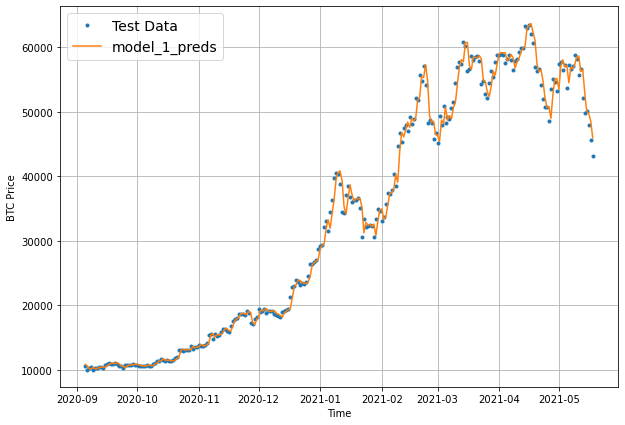

In [71]:
# Lets plot our model_1 predictions
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values = test_labels[:,0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)



In [72]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [73]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [74]:
# Make train and testind windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [75]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)

model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)  # need to predict horizon number of steps into the future                         
], name="model_2_dense")


model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())


model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: mod

In [76]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 581us/step - loss: 658.0291


658.0291137695312

In [77]:
# Load in the best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 604us/step - loss: 608.8481


608.8480834960938

In [78]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

In [79]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 608.84814,
 'mse': 1284314.6,
 'rmse': 1133.276,
 'mape': 2.7680666,
 'mase': 1.0642725}

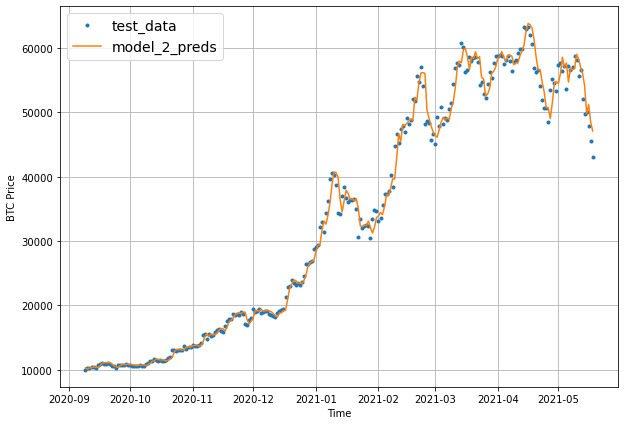

In [80]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds") 

In [81]:
test_labels.shape

(552, 1)

In [82]:
test_labels[:10]

array([[8749.52059102],
       [8656.97092235],
       [8500.64355816],
       [8469.2608989 ],
       [8537.33965197],
       [8205.80636599],
       [8118.4885358 ],
       [8074.84317361],
       [7612.7405735 ],
       [7262.11053495]])

In [83]:
test_labels[:10,0] # get the 0th column values from the (:10,1) 

array([8749.52059102, 8656.97092235, 8500.64355816, 8469.2608989 ,
       8537.33965197, 8205.80636599, 8118.4885358 , 8074.84317361,
       7612.7405735 , 7262.11053495])

In [84]:
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8903.552 , 8932.771 , 8792.955 , 8590.41  , 8454.577 , 8345.147 ,
       8289.814 , 8157.1304, 8205.853 , 7836.601 ], dtype=float32)>

Below is an explaination of how the data is divided for lesser confusion

In [85]:
test_labels.shape

(552, 1)

In [86]:
len(prices)

2787

In [87]:
X_test.shape

(558,)

In [88]:
y_test.shape

(558,)

In [89]:
train_windows.shape

(2205, 30)

In [90]:
test_windows.shape

(552, 30)

In [91]:
train_labels.shape

(2205, 1)

In [92]:
test_labels.shape

(552, 1)

In [93]:
len(prices)

2787

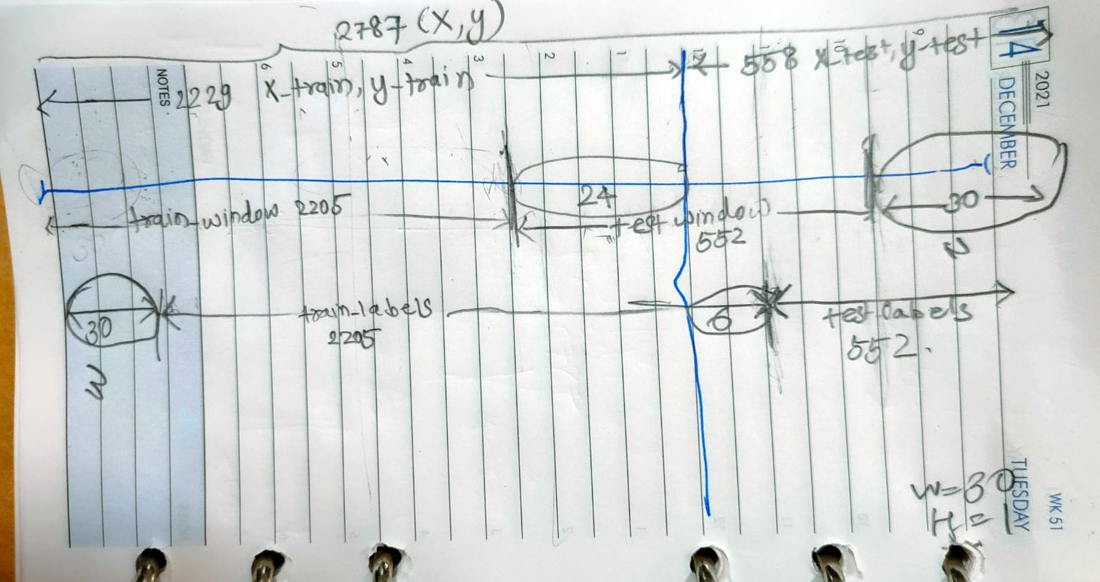

## Model 3: Dense (window = 30, horizon = 7)

In [94]:
prices[:10]

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  , 123.033  , 124.049  , 125.96116])

In [95]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows),len(full_labels)

(2751, 2751)

In [96]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows = full_windows,
                                                                                labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [97]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
   layers.Dense(128, activation="relu"),
   layers.Dense(HORIZON)                            
], name="model_3_dense")


model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: mod

In [98]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1340.7281


1340.7281494140625

In [99]:
# Load best version of model_3 and evaluate

model_3= tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1234.2446


1234.24462890625

In [100]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9003.453, 9119.054, 9420.311, 9238.845, 9422.83 , 9508.362,
        9394.428],
       [8732.304, 8906.92 , 9238.808, 8860.409, 9024.207, 9123.871,
        9198.526],
       [8694.456, 8849.666, 9129.243, 8763.897, 8954.177, 8972.333,
        9097.519],
       [8881.504, 8850.816, 9043.497, 8927.656, 8962.723, 9137.217,
        9088.558],
       [8816.98 , 8839.664, 8916.82 , 8846.279, 9130.221, 9219.978,
        8989.626]], dtype=float32)>

In [101]:
model_2_results

{'mae': 608.84814,
 'mse': 1284314.6,
 'rmse': 1133.276,
 'mape': 2.7680666,
 'mase': 1.0642725}

In [102]:
model_3_preds.shape, model_2_preds.shape

(TensorShape([551, 7]), TensorShape([552]))

In [103]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([ 507.82535 ,  329.46637 ,  329.24902 ,  357.97266 ,  411.30484 ,
         534.5418  ,  550.95746 ,  488.12494 ,  571.9726  ,  680.97766 ,
         832.5098  ,  749.4463  ,  723.03503 ,  784.4811  ,  577.76013 ,
         264.375   ,  189.52232 ,  181.47678 ,  247.50844 ,  298.8604  ,
         133.26096 ,  172.44377 ,  175.17627 ,  227.49973 ,  139.84744 ,
         128.80789 ,  140.85135 ,  180.04541 ,  164.06369 ,  208.03377 ,
         300.55453 ,  364.22754 ,  262.69174 ,  281.55865 ,  276.28802 ,
         250.6693  ,  312.68597 ,  258.40353 ,  182.72287 ,  209.38756 ,
         372.62445 ,  144.52379 ,  135.59766 ,  119.52071 ,   83.09333 ,
          56.13867 ,   67.699844,  102.461494,  121.71826 ,  156.48305 ,
         163.04646 ,  134.90227 ,  175.92815 ,  129.50795 ,  256.68597 ,
         357.5632  ,  541.4642  ,  559.4257  ,  532.50385 ,  536.22797 ,
         463.11496 ,  271.49213 ,  262.56564 ,  308.8247  ,  460.99713 ,
         466.16    ,  510.15933 ,  528.8156 

## Make our evaluation function work for larger horizons

In [104]:
model_3_results['mae'].shape

(551,)

In [105]:
model_2_results['mae'].shape

()

In [106]:
model_3_results['mae'].ndim

1

In [107]:
model_2_results['mae'].ndim

0

In [108]:
# Create a function to take  in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)


  # Account for different sized metrics (for longer horizons, reduce to single number)

  if mae.ndim>0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)


  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [109]:
# Get model_3 results aggregated to single value
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)

model_3_results

{'mae': 1234.2448,
 'mse': 5375467.5,
 'rmse': 1418.8019,
 'mape': 5.5360065,
 'mase': 2.196269}

In [110]:
test_labels[:5]

array([[8794.35864452, 8798.04205463, 9081.18687849, 8711.53433917,
        8760.89271814, 8749.52059102, 8656.97092235],
       [8798.04205463, 9081.18687849, 8711.53433917, 8760.89271814,
        8749.52059102, 8656.97092235, 8500.64355816],
       [9081.18687849, 8711.53433917, 8760.89271814, 8749.52059102,
        8656.97092235, 8500.64355816, 8469.2608989 ],
       [8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 , 8537.33965197],
       [8760.89271814, 8749.52059102, 8656.97092235, 8500.64355816,
        8469.2608989 , 8537.33965197, 8205.80636599]])

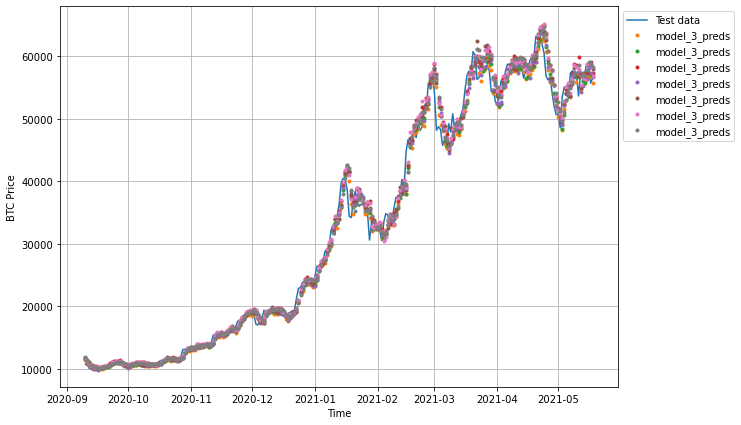

In [111]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset,format="-", label="Test data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

plt.legend(loc= "upper left" , bbox_to_anchor=(1.0, 1.0)) # use upper left(for bbox_to_anchor  (0,0) is the bottom left)

In [112]:
model_3_preds.shape

TensorShape([551, 7])

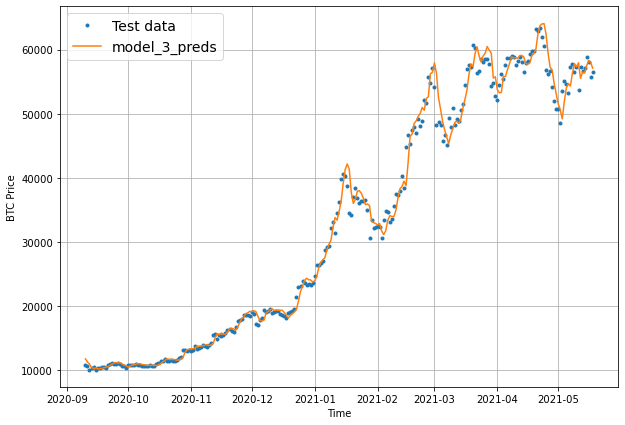

In [113]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), start=offset,format="-", label="model_3_preds")

## Which of our models is performing best so far?

So far, we've trained 3 models which use the same architecture but use different data inputs.

Let's compare them with the naïve model to see which model is performing the best so far.

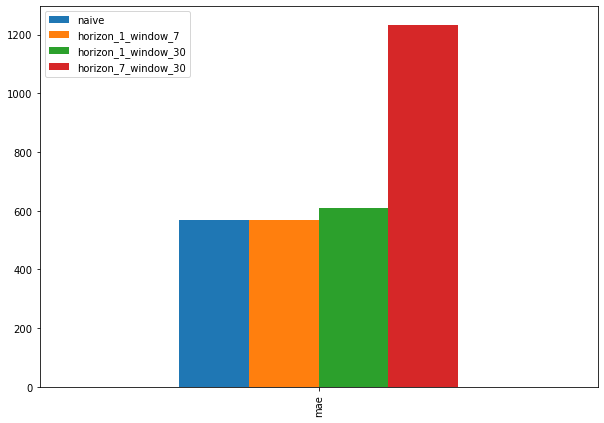

In [114]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

Woah, our naïve model is performing best (it's very hard to beat a naïve model in open systems) but the dense model with a horizon of 1 and a window size of 7 looks to be performing cloest.

Because of this, let's use `HORIZON=1` and `WINDOW_SIZE=7` for our next series of modelling experiments (in other words, we'll use the previous week of Bitcoin prices to try and predict the next day).

> 🔑 **Note:** You might be wondering, why are the naïve results so good? One of the reasons could be due the presence of **autocorrelation** in the data. If a time series has **autocorrelation** it means the value at `t+1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is, a naïve model will often get fairly good results.

> 📖 **Resource:** For more on how autocorrelation influences a model's predictions, see the article [*How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls*](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424) by Vegard Flovik

In [115]:
# #  Calculate autocorrelation
#  import statsmodels.api as sm
#  sm.tsa.acf(prices, nlags=1)

## Model 4: Conv1D

In [116]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [117]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon= HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [118]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

To Use the Conv1D layer, we need an input shape of (`batch_size, timesteps, input_dim`)...


However our data isn't in that shape yet

In [119]:
train_windows.shape

(2224, 7)

In [120]:
# Check our  data input shape

train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

In [121]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [122]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # Add an extra dimension for `input_dim` 


In [123]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [124]:
x.numpy()

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])

In [125]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
   layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
   layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
   layers.Dense(HORIZON)                            
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets wr

In [126]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1, 7)              0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 128)            4608      
_________________________________________________________________
dense_6 (Dense)              (None, 1, 1)              129       
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [127]:
#Evaluate model
model_4.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 624.1890


624.18896484375

In [128]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model('model_experiments/model_4_conv1D')
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 569.0327


569.03271484375

In [129]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8847.292 , 8757.503 , 8997.47  , 8762.802 , 8707.723 , 8713.594 ,
       8664.936 , 8496.83  , 8439.472 , 8499.3955], dtype=float32)>

In [130]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 569.0327,
 'mse': 1169841.5,
 'rmse': 1081.5922,
 'mape': 2.5515258,
 'mase': 0.9996329}

##Model 5: RNN (LSTM)

Let's build an RNN model for our time series data

we'll use the same data created previously

In [131]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))

x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# x = layers.LSTM(128, return_sequences=True)(x)
x= layers.LSTM(128, activation="relu")(x)
# x= layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

#Fit
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data = (test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
18/18 [==============================] - 1s 15ms/step - loss: 2323.6123 - val_loss: 9225.3408
INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 695.5120 - val_loss: 1486.2166
INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 237.3829 - val_loss: 1298.9418
INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 181.9194 - val_loss: 966.6409
INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 173.4039 - val_loss: 970.9379
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 172.3026 - val_loss: 868.5317
INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets
Epoch 7/100


18/18 [==============================] - 0s 6ms/step - loss: 116.1540 - val_loss: 631.3999
INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets
Epoch 60/100
18/18 [==============================] - 0s 6ms/step - loss: 116.1320 - val_loss: 627.9650
INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets
Epoch 61/100
18/18 [==============================] - 0s 6ms/step - loss: 115.7767 - val_loss: 663.2509
Epoch 62/100
18/18 [==============================] - 0s 6ms/step - loss: 117.8910 - val_loss: 683.4460
Epoch 63/100
18/18 [==============================] - 0s 7ms/step - loss: 119.8410 - val_loss: 622.3526
INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 113.9402 - val_loss: 647.8842
Epoch 65/100
18/18 [==============================] - 0s 6ms/step - loss: 116.0785 - val_loss: 618.2653
INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\

In [132]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 591.6340


591.6339721679688

In [133]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8968.139 , 8806.982 , 9008.919 , 8826.417 , 8728.811 , 8789.618 ,
       8726.521 , 8534.258 , 8507.6455, 8533.323 ], dtype=float32)>

In [134]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 591.6341,
 'mse': 1254265.8,
 'rmse': 1119.9401,
 'mape': 2.6527543,
 'mase': 1.0393373}

Hmmm... it seems even with an LSTM-powered RNN we weren't able to beat our naïve models results.

Perhaps adding another variable will help?

> 🔑 **Note:** I'm putting this here again as a reminder that because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results. You're probably starting to clue onto this now.

##Make a multivariate time series

Before we add a feature to our time series, what is a feature we can use?

One feature we could add is whether or not  Daniel Bourke Tweeted  on that day...

* day 1 - 0
* day 2 - 1
* day 3 - 0

Whats a better feature to use?

How about the bitcoin halving events?

https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving


In [135]:
# Lets make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [136]:
# Lets add the bitcoin halving events to our dataset
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [137]:

bitcoin_prices.index[0]

Timestamp('2013-10-01 00:00:00')

In [138]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days,block_reward_3_days

(1012, 2414)

In [139]:
# Add in a block reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"]= None


# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()


,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [140]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


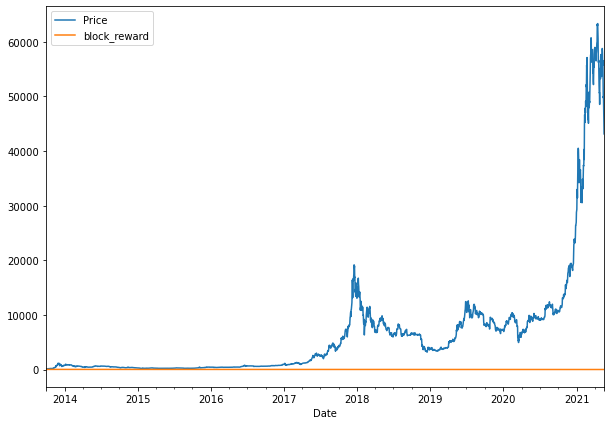

In [141]:
bitcoin_prices_block.plot(figsize=(10, 7));
# As u can see the data is not scaled properly

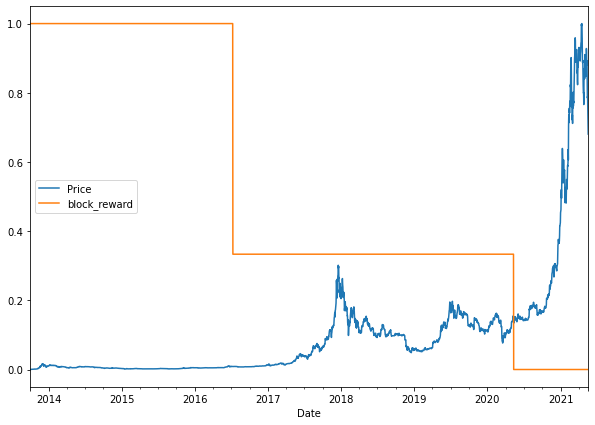

In [142]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.

from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns = bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

scaled_price_block_df.plot(figsize=(10, 7));

## Making a windowed dataset with pandas

Previously, we used some custom made functions to window our **univariate** time series.

However, since we've just added another variable to our dataset, these functions won't work.

Not to worry though. Since our data is in a pandas DataFrame, we can leverage the [`pandas.DataFrame.shift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) method to create a windowed **multivariate** time series.

The `shift()` method offsets an index by a specified number of periods.

Let's see it in action.

In [143]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [144]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

#Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


What we've done is created a way to window our dataset directly from pandas dataframe


```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [145]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32) 
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [146]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [147]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)

In [148]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)                             
], name="model_6_dense_multivariate")


# Compile
model_6.compile(loss="mae",
                optimizer= tf.keras.optimizers.Adam())

# Fit

model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets
INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets
INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets
INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets
INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets
INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets
INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets
INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets
INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets
INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets
INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets
INFO:tensorflow:Assets written to: model_ex

In [149]:
# Make sure best model is loaded and evaluate
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 647us/step - loss: 645.7141


645.7140502929688

In [150]:
# Load in and evaluate best performing model
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test,y_test)

18/18 [==============================] - 0s 2ms/step - loss: 568.3355


568.3355102539062

In [151]:
# Make predictions on the multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8845.382, 8769.116, 9044.852, 8745.515, 8727.063, 8773.182,
       8669.289, 8502.58 , 8469.249, 8527.998], dtype=float32)>

In [152]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 568.3355,
 'mse': 1164860.1,
 'rmse': 1079.2869,
 'mape': 2.5493138,
 'mase': 0.9984081}

In [153]:
model_1_results

{'mae': 568.54987,
 'mse': 1172588.0,
 'rmse': 1082.8611,
 'mape': 2.5492291,
 'mase': 0.99878466}

> 📖 **Resource:** For different ideas on how to improve a neural network model (from a model perspective), refer to the [*Improving a model*](https://dev.mrdbourke.com/tensorflow-deep-learning/02_neural_network_classification_in_tensorflow/#improving-a-model) section in notebook 02.

## Model 7: N-BEATS algorithm

We're going to be replicating the algorithm in figure 1 from the following paper [N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) algorithm](https://arxiv.org/pdf/1905.10437.pdf)

why?

* This will allow us to practice replicating a paper with tensorflow code
* We will see how to use tensorflow layer subclassing (to make our own  custom layers)
* Get experience usig the functional API to create a custom architecture
* Potentially get state of the art results on our problem


### Building and testing an N-BEATS block layer

Because the N-Beats block layer does'nt exist in Tensorflow, we've got to create it.

To create custom layers and models in tensorflow we can use subclassing:
https://www.tensorflow.org/guide/keras/custom_layers_and_models


In [154]:
# create NBeatsBlock custom Layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size : int,
               theta_size : int,
               horizon : int,
               n_neurons : int,
               n_layers : int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)

    super().__init__(**kwargs) # Pass kwargs to the parent class constructor (tf.keras.layers.Layer)
    
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast



Let's test our NBeatsBlock class.

To do we'll make some dummy inputs and outputs.

In [155]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size = WINDOW_SIZE + HORIZON,  # backcast + forecast
                                       horizon = HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [156]:
# Create Dummy inputs(have to be same size as input size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]])>

In [157]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.19014972  0.8379835  -0.32870024  0.2515991  -0.47540277 -0.7783665
 -0.52994466]
Forecast: -0.7554213404655457


### Preparing data for the N-BEATS algorithm using `tf.data`

To make our input data load as fast as possible we're going to be adhering to the performent data pipeline steps in the tf.data guide
https://www.tensorflow.org/guide/data_performance


In [158]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [159]:
# Create N-BEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()


,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [160]:
# Add windowed columns 
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [161]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [162]:
X_train.shape, y_train.shape

# As seen below.. from tensor slices gives a set of 7 for every 2224 values in X_train and zip joins the sets with each one of the 2224 labels

((2224, 7), (2224,))

In [163]:
# Time to make our dataset performant using the tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


train_dataset, test_dataset


(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

### Setting up hyperparameters for N-BEATS algorithm
The N-BEATS algorithmmhas a fair few number of parameters, many of them can be found in table 18 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)

![table 18 from N-BEATS paper](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-table-18-hyperparameters.png)
*Table 18 from [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf) describing the hyperparameters used for the different variants of N-BEATS. We're using N-BEATS-G which stands for the generic version of N-BEATS.*

In [164]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE


(7, 8)

### Getting ready for residual connections

Befor we can craft our N-Beats model, we need two layers for the residual connections(subtract and add).

The N-Beats algorithm uses  double residual stacking to help train its deeper architecture (section 3.2 of N-BEATS paper)

For more on residual connections see: https://en.wikipedia.org/wiki/Residual_neural_network

And here: https://paperswithcode.com/method/resnet


In [165]:
# Make Tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

#Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

#Add
added = layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the N-BEATS algorithm


Okay, we've finally got all of the pieces of the puzzle ready for building and training the N-BEATS algorithm.

We'll do so by going through the following:

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional) for this)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use a for loop to create stacks of block layers
5. Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf))
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * [`tf.keras.callbacks.EarlyStopping()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using `restore_best_weights=True` (this'll prevent the model from training for loooongggggg period of time without improvement)
  * [`tf.keras.callbacks.ReduceLROnPlateau()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)

Woah. A bunch of steps. But I'm sure you're up to it.

Let's do it!

In [166]:
%%time

tf.random.set_seed(42)

# 1. Setup an instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size = INPUT_SIZE,
                                 theta_size = THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons= N_NEURONS,
                                 n_layers = N_LAYERS,
                                 name="InitialBlock")  # since we put **kwargs we can add this name

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of block layers

for i, _ in enumerate(range(N_STACKS-1)): # first stack is already created in (3)
  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs = stack_input,
                          outputs=forecast,
                          name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam(0.001),
                metrics = ["mae","mse"])


# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs = N_EPOCHS,
            validation_data = test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])




Epoch 00272: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00372: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Wall time: 28min 21s


In [167]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 418ms/step - loss: 579.2164 - mae: 579.2164 - mse: 1151403.5000


[579.2164306640625, 579.2164306640625, 1151403.5]

In [168]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8907.102, 8822.188, 9036.951, 8796.419, 8742.789, 8764.459,
       8667.616, 8537.421, 8475.521, 8525.012], dtype=float32)>

In [169]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 579.21643,
 'mse': 1151403.5,
 'rmse': 1073.0347,
 'mape': 2.6935654,
 'mase': 1.0175228}

In [170]:
model_1_results

{'mae': 568.54987,
 'mse': 1172588.0,
 'rmse': 1082.8611,
 'mape': 2.5492291,
 'mase': 0.99878466}

In [171]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.9995699}

Woah... even with all of those special layers and hand-crafted network, it looks like the N-BEATS model doesn't perform as well as `model_1` or the original naive forecast.

This goes to show the power of smaller networks as well as the fact not all larger models are better suited for a certain type of data.



### Plotting the N-BEATS architecture we've created

In [225]:
# Since I was getting an error I commented this cell
# (Works well on colab)

# # Plot the N-BEATS model and inspect the architecture
# from tensorflow.keras.utils import plot_model
# plot_model(model_7)

## Model 8: Creating an ensemble (stacking different models together)

An ensemble leverages the wisdom of the crowd effect.

It combines many *different* models to predict a common goal

In [173]:
HORIZON, WINDOW_SIZE

(1, 7)

### Constructing and fitting an ensemble of models (using different loss functions) 

In [174]:
def get_ensemble_models(horizons = HORIZON,
                        train_data = train_dataset,
                        test_data = test_dataset,
                        num_iter=10,
                        num_epochs = 1000,
                        loss_fns = ["mae","mse","mape"]):
  
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """

  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")


      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal  
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"), # he_normal is weight initializer
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                                 
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae","mse"])
      
      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                           patience=200,
                                                           restore_best_weights=True),
                          tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                               patience=100,
                                                               verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models    

In [175]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 00606: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00722: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00822: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 00145: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00250: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00350: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 00338: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00438: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizi

In [176]:
len(ensemble_models) # 5 Iters and 3 loss functions

15

### Making predictions with an ensemble model

In [177]:
# create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)  # make predictions with current ensemble model
    ensemble_preds.append(preds)

  return tf.constant(tf.squeeze(ensemble_preds))

In [178]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8756.326 ,  8755.483 ,  9043.827 , ..., 50323.402 , 49588.645 ,
        46552.14  ],
       [ 8765.933 ,  8741.82  ,  9052.941 , ..., 49350.02  , 48521.934 ,
        45325.324 ],
       [ 8720.9795,  8700.447 ,  9080.199 , ..., 49687.934 , 47592.586 ,
        44999.883 ],
       ...,
       [ 8815.072 ,  8719.844 ,  9067.604 , ..., 49660.656 , 49773.05  ,
        46537.477 ],
       [ 8730.953 ,  8807.447 ,  9104.015 , ..., 49610.305 , 48546.016 ,
        45078.086 ],
       [ 8812.579 ,  8784.1875,  9025.107 , ..., 49931.77  , 48238.234 ,
        45675.93  ]], dtype=float32)>

In [179]:
y_test

Date
2019-11-10     8798.042055
2019-11-11     9081.186878
2019-11-12     8711.534339
2019-11-13     8760.892718
2019-11-14     8749.520591
                  ...     
2021-05-14    49764.132082
2021-05-15    50032.693137
2021-05-16    47885.625255
2021-05-17    45604.615754
2021-05-18    43144.471291
Name: Price, Length: 556, dtype: float64

Our ensemble preds come out in multiple dimensions but to combine into **point Predictions** we can leverage the mean of all the predictions or the median - https://machinelearningmastery.com/combine-predictions-for-ensemble-learning/

In [180]:
ensemble_mean = tf.reduce_mean(ensemble_preds,axis=1)
ensemble_mean

<tf.Tensor: shape=(15,), dtype=float32, numpy=
array([20013.535, 20047.672, 20039.3  , 20005.342, 20065.137, 20080.773,
       20118.09 , 20032.205, 20080.79 , 20082.594, 20058.945, 20084.256,
       20084.824, 20064.443, 20063.18 ], dtype=float32)>

In [181]:
ensemble_mean = tf.reduce_mean(ensemble_preds,axis=0)
ensemble_mean

<tf.Tensor: shape=(556,), dtype=float32, numpy=
array([ 8777.31  ,  8775.004 ,  9063.8545,  8724.025 ,  8741.656 ,
        8712.372 ,  8658.96  ,  8473.924 ,  8448.194 ,  8521.143 ,
        8194.355 ,  8097.395 ,  8043.221 ,  7620.488 ,  7276.6597,
        7307.444 ,  7081.9624,  7210.4614,  7106.802 ,  7535.2476,
        7379.288 ,  7744.7593,  7554.841 ,  7383.03  ,  7315.527 ,
        7308.6514,  7205.438 ,  7386.6094,  7503.696 ,  7533.19  ,
        7537.898 ,  7321.3857,  7226.2036,  7174.8325,  7185.3594,
        7229.4624,  7074.3667,  7095.627 ,  6862.3438,  6581.7446,
        7406.969 ,  7169.924 ,  7167.727 ,  7260.8403,  7262.83  ,
        7192.763 ,  7214.3887,  7202.336 ,  7173.7266,  7207.5425,
        7300.435 ,  7380.036 ,  7238.6426,  7162.503 ,  7154.703 ,
        6944.812 ,  7280.2456,  7331.42  ,  7357.491 ,  7705.664 ,
        8059.709 ,  8132.0845,  7849.758 ,  8084.8223,  8092.635 ,
        8168.009 ,  8092.349 ,  8747.917 ,  8888.176 ,  8763.157 ,
        8932.7

In [182]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median

array([ 8775.708 ,  8782.654 ,  9052.941 ,  8715.853 ,  8751.601 ,
        8717.99  ,  8654.84  ,  8483.005 ,  8452.654 ,  8515.345 ,
        8201.086 ,  8103.579 ,  8043.1304,  7620.1284,  7273.832 ,
        7302.7764,  7074.142 ,  7209.8076,  7115.019 ,  7543.095 ,
        7395.098 ,  7745.219 ,  7558.448 ,  7387.343 ,  7318.9204,
        7303.878 ,  7201.301 ,  7381.2363,  7496.9272,  7538.026 ,
        7541.6787,  7323.266 ,  7221.998 ,  7176.5347,  7177.566 ,
        7221.3496,  7073.0483,  7098.375 ,  6865.8335,  6581.6333,
        7404.986 ,  7161.082 ,  7165.216 ,  7271.265 ,  7243.9946,
        7192.747 ,  7222.268 ,  7202.7285,  7176.4272,  7215.013 ,
        7301.2417,  7381.5254,  7244.1274,  7168.676 ,  7158.9434,
        6943.901 ,  7271.605 ,  7323.4165,  7361.381 ,  7723.457 ,
        8054.234 ,  8127.9053,  7847.3706,  8085.378 ,  8097.6626,
        8173.7935,  8103.866 ,  8747.294 ,  8891.366 ,  8772.224 ,
        8944.599 ,  8949.483 ,  8660.475 ,  8631.496 ,  8685.4

In [183]:
# we took median or mean because of this function- evaluate_preds..

In [184]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=tf.reduce_mean(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 567.5192,
 'mse': 1147057.5,
 'rmse': 1071.0077,
 'mape': 2.5806024,
 'mase': 0.9969741}

In [185]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 566.6532,
 'mse': 1149246.6,
 'rmse': 1072.0292,
 'mape': 2.5763278,
 'mase': 0.9954527}

###Plotting the prediction intervals (uncertainty estimates) of our ensemble

So far we've been making point prdictions with our models.

Eg.: horizon=1, our model predicts tomorrow's price of bitcoin will be $50,000USD.

Would'nt it be helpfull if we knew a range of where that prediction came from?

Instead of 50,000 USD on the dot, how about 48,000 to 52,000 USD?

One way to get th 95% confidence prediction intervals for a deep learning model is the bootstraping method:

1. Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble model)
2. Measure the standard deviation of the predictions
3. Multiply standard deviation by [1.96](https://en.wikipedia.org/wiki/1.96) (assuming the distribution is Gaussian/Normal, 95% of observations fall within 1.96 standard deviations of the mean, this is why we initialized our neural networks with a normal distribution)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)

In [186]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks
  
  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96 

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper


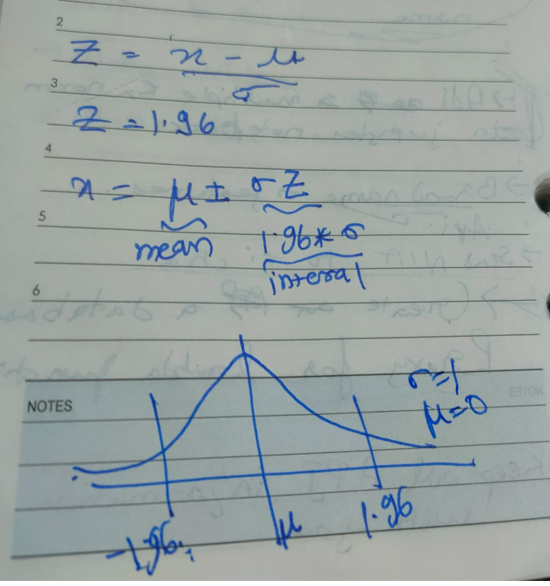

In [187]:
# Get the upper and lower bounds of the 95% 
lower, upper = get_upper_lower(preds=ensemble_preds)
lower, upper

(<tf.Tensor: shape=(556,), dtype=float32, numpy=
 array([ 8709.243 ,  8702.49  ,  9003.472 ,  8646.183 ,  8662.778 ,
         8662.448 ,  8587.02  ,  8397.5205,  8395.152 ,  8480.524 ,
         8142.4985,  8036.1196,  8000.191 ,  7567.0347,  7207.43  ,
         7224.3955,  6965.755 ,  7127.503 ,  7001.61  ,  7462.7275,
         7310.9155,  7678.171 ,  7479.8364,  7286.4023,  7258.3467,
         7251.4062,  7149.265 ,  7347.5386,  7464.0923,  7493.7437,
         7481.3794,  7268.331 ,  7182.414 ,  7140.425 ,  7144.1924,
         7179.538 ,  7032.129 ,  7056.5366,  6820.827 ,  6546.436 ,
         7298.086 ,  7076.7065,  7070.6934,  7169.078 ,  7100.001 ,
         7085.826 ,  7176.2114,  7170.561 ,  7140.152 ,  7173.3086,
         7267.862 ,  7350.9487,  7194.548 ,  7121.436 ,  7127.616 ,
         6908.366 ,  7231.648 ,  7275.5327,  7305.3413,  7612.808 ,
         7973.1245,  8057.3374,  7773.603 ,  8021.162 ,  8022.291 ,
         8122.9756,  8024.033 ,  8680.136 ,  8805.206 ,  8669.552 ,

> 📖 **Resource(s):** 
> * The steps we're about to take have been inspired by the Machine Learning Mastery blog post [*Prediction Intervals for Deep Learning Neural Networks*](https://machinelearningmastery.com/prediction-intervals-for-deep-learning-neural-networks/). Check out the post for more options to measure uncertainty with neural networks.
> * For an example of uncertainty estimates being used in the wild, I'd also refer to Uber's [*Engineering Uncertainty Estimation in Neural Networks for Time Series Prediction at Uber*](https://eng.uber.com/neural-networks-uncertainty-estimation/) blog post.

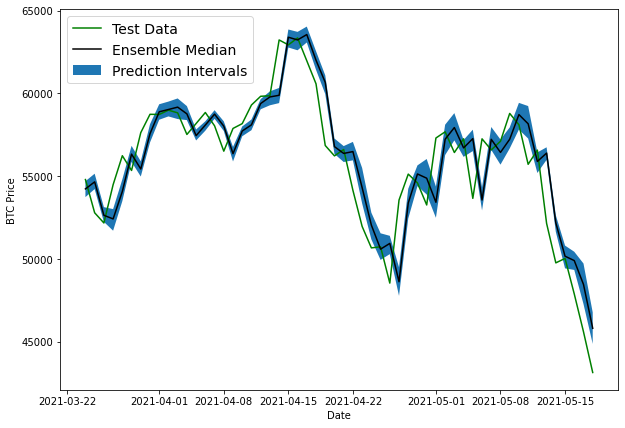

In [188]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis = 0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")

# To plot the upper and lower bounds lets use fill between: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")

plt.legend(loc="upper left", fontsize=14);

Hmm...

So far all of our test models predictions have been lagging behind the test data..

As they're replicating what the naive model does and just predict the previous timestep.

> 🔑 **Note:**  These prediction intervals are estimatesthemselves. And they havebeen created with the assumption that our model's data is from a normal distribution

## Aside: two types of uncertainty (coconut and subway)

Uncrtainty estimates in machine learning seek out to qualitatively and quntitavely answer the questions:
1. What can my model know? (with perfect data, whats possible for a model to learn)
2. What doesn't my model know? (what can a model never predict? or or would it be helpful if a model could tell you that when its making a prediction it doesn't actually know if it is right or not?)

There are two major types of uncertainty in machine learning you should know about:

* **Aleatoric uncertainty** - this type of uncertainty cannot be reduced, it is also referred to as "data" or "subway" uncertainty.

 * Let's say your train is scheduled to arrive at 10:08am but very rarely does it arrive at *exactly* 10:08am. You know it's usually a minute or two either side and perhaps up to 10-minutes late if traffic is bad. Even with all the data you could imagine, this level of uncertainty is still going to be present (much of it being noise).
  * When we measured prediction intervals, we were measuring a form of subway uncertainty for Bitcoin price predictions (a little either side of the point prediction).

* **Epistemic uncertainty** - this type of uncertainty can be reduced, it is also referred to as "model" or "coconut" uncertainty, it is very hard to calculate.
 * The analogy for coconut uncertainty involves whether or not you'd get hit on the head by a coconut when going to a beach. 
    * If you were at a beach with coconuts trees, as you could imagine, this would be very hard to calculate. How often does a coconut fall of a tree? Where are you standing? 
    * But you could reduce this uncertainty to zero by going to a beach without coconuts (collect more data about your situation).
  * Model uncertainty can be reduced by collecting more data samples/building a model to capture different parameters about the data you're modelling.



## Model 9: Train a model on the full historical data to make predictions into future

So far all of our models have predicted on the test dataset, however, this is only a pseudofuture.

Lets now build a model which is capable of predicting into the future

In [189]:
# HORIZON = 1
# WINDOW_SIZE = 7

In [190]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [191]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


In [192]:
# Train model on entire data to make prediction for the next day 
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()

# Get labels
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

len(X_all), len(y_all)

(2780, 2780)

In [193]:
X_all[:10], y_all[:10]

(array([[121.795  , 120.65533, 121.33866, 118.67466, 108.58483, 125.455  ,
         123.65499],
        [123.033  , 121.795  , 120.65533, 121.33866, 118.67466, 108.58483,
         125.455  ],
        [124.049  , 123.033  , 121.795  , 120.65533, 121.33866, 118.67466,
         108.58483],
        [125.96116, 124.049  , 123.033  , 121.795  , 120.65533, 121.33866,
         118.67466],
        [125.27966, 125.96116, 124.049  , 123.033  , 121.795  , 120.65533,
         121.33866],
        [125.9275 , 125.27966, 125.96116, 124.049  , 123.033  , 121.795  ,
         120.65533],
        [126.38333, 125.9275 , 125.27966, 125.96116, 124.049  , 123.033  ,
         121.795  ],
        [135.24199, 126.38333, 125.9275 , 125.27966, 125.96116, 124.049  ,
         123.033  ],
        [133.20333, 135.24199, 126.38333, 125.9275 , 125.27966, 125.96116,
         124.049  ],
        [142.76333, 133.20333, 135.24199, 126.38333, 125.9275 , 125.27966,
         125.96116]]),
 array([123.033  , 124.049  , 125.9611

In [194]:
# Turn data into efficient running tensors

features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all,labels_dataset_all))

# 3. Batch and prefetch for optimal performance

BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>

In [195]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
   layers.Dense(128, activation="relu"),
   layers.Dense(128, activation="relu"),
   layers.Dense(HORIZON)                            
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0) # don't print out anything, we've seen this all before

## Make predictions on the future

In [196]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14 # since our Bitcoin data is daily, this is for 14 days(2 weeks)


To make predictions into the future we want a function which:

1. Takes as input: 
  * a list of values (the Bitcoin historical data)
  * a trained model (such as `model_9`)
  * a window into the future to predict (our `INTO_FUTURE` variable)
  * the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the function) and extracts the last `WINDOW_SIZE` values from the input values (predictions will start from the last `WINDOW_SIZE` values of the training data)
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` datasets which update to remove the first the value and append the latest prediction 
  * Eventually future predictions will be made using the model's own previous predictions as input

In [197]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time 
  for _ in range(INTO_FUTURE):
    
    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [198]:
# Make forecasts into future of the price of Bitcoin
future_forecast = make_future_forecast(values=y_all,
                                        model=model_9,
                                        into_future=INTO_FUTURE,
                                        window_size=WINDOW_SIZE)

Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55809.94921875

Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55809.94921875] -> Prediction: 51012.7265625

Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55809.94921875 51012.7265625 ] -> Prediction: 48570.9921875

Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55809.94921875 51012.7265625  48570.9921875 ] -> Prediction: 48183.12109375

Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 55809.94921875
 51012.7265625  48570.9921875  48183.12109375] -> Prediction: 47952.60546875

Predicting on: 
 [45604.61575361 43144.47129086 55809.94921875 51012.7265625
 48570.9921875  48183.12109375 47952.60546875] -> Prediction: 46935.30078125

Predicting on: 
 [43144.47129086 55809.94921875 51012.7265625  4857

### Plot future forecasts

In [199]:
future_forecast

[55809.95,
 51012.727,
 48570.992,
 48183.12,
 47952.605,
 46935.3,
 48375.38,
 54034.594,
 49756.44,
 47702.387,
 48251.562,
 48950.188,
 48769.414,
 50383.37]

In [200]:
bitcoin_prices_windowed.tail(1)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


In [201]:
def get_future_dates(start_date, into_future, offset=1): # Offset is 1 for 1 day at a time
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """

  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  
  return np.arange(start_date, end_date, dtype = "datetime64[D]") # return a date range between start date and end date


In [202]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [203]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future = INTO_FUTURE)

next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [204]:
bitcoin_prices.index

DatetimeIndex(['2013-10-01', '2013-10-02', '2013-10-03', '2013-10-04',
               '2013-10-05', '2013-10-06', '2013-10-07', '2013-10-08',
               '2013-10-09', '2013-10-10',
               ...
               '2021-05-09', '2021-05-10', '2021-05-11', '2021-05-12',
               '2021-05-13', '2021-05-14', '2021-05-15', '2021-05-16',
               '2021-05-17', '2021-05-18'],
              dtype='datetime64[ns]', name='Date', length=2787, freq=None)

In [205]:
# Insert last timestep/final price so the graph doesn't look messed

# Can try running the plot without this to see the difference

next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55809.95 , 51012.727, 48570.992, 48183.12 , 47952.605,
        46935.3  , 48375.38 , 54034.594, 49756.44 , 47702.387, 48251.562,
        48950.188, 48769.414, 50383.37 ], dtype=float32))

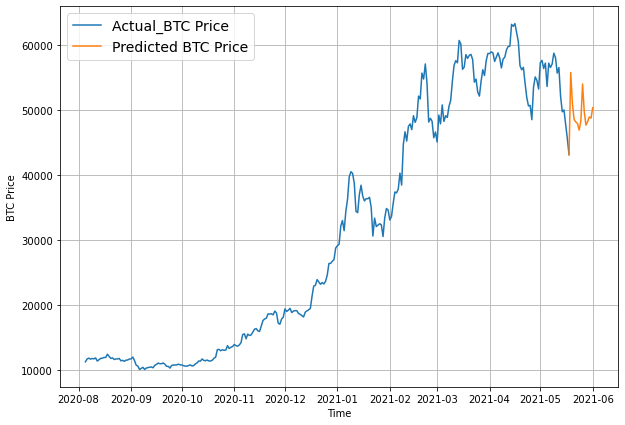

In [206]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format='-', label="Actual_BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

## Model 10: Why forecasting is BS (the turkey problem 🦃)

In [207]:
# Let's introduce a Turkey problem to our BTC data (price BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [208]:
# Manufacture an extra price on the end (to showcase the Turkey problem)
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

Notice the last value is 100x lower than what it actually was (remember, this is not a real data point, its only to illustrate the effects of the turkey problem).

Now we've got Bitcoin prices including a turkey problem data point, let's get the timesteps.

In [209]:
# Get the timesteps for the turkey problem 
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

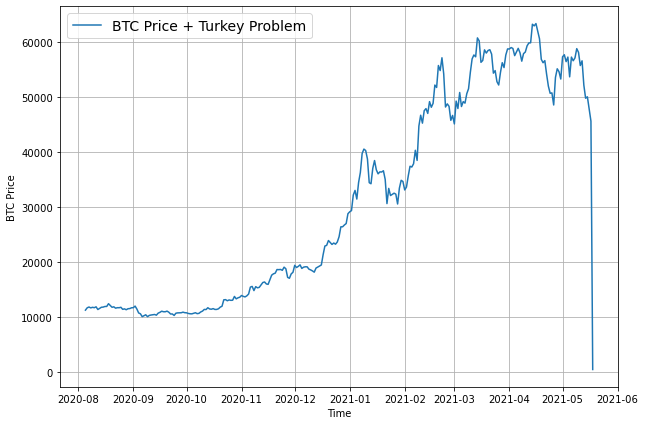

In [210]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-", 
                 label="BTC Price + Turkey Problem", 
                 start=2500)

In [211]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)


(2224, 556, 2224, 556)

In [212]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


### Building a turkey model (model to predict on turkey data)

In [213]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "model_10_turkey_model" # using ._name u can change the name of a model
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())

turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 batch_size=128,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)]) 

INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets
INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets
INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets
INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets
INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets
INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets
INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets
INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets
INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets
INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets
INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets
INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets
INFO:tensorflow:

In [214]:
# Evaluate turkey model on test data
turkey_model.evaluate(X_test,y_test)

18/18 [==============================] - 0s 1ms/step - loss: 701.3096


701.3096313476562

In [215]:
# Load best model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_experiments/model_10_turkey_model/")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 1ms/step - loss: 639.4270


639.427001953125

In [216]:
# Make predictions with Turkey model
turkey_preds = make_preds(turkey_model,X_test)
turkey_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8855.644, 8789.629, 9038.993, 8794.518, 8762.856, 8737.98 ,
       8679.886, 8547.627, 8457.897, 8536.621], dtype=float32)>

In [217]:
# Evaluate turkey preds

turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)

turkey_results

{'mae': 17136.684,
 'mse': 614939400.0,
 'rmse': 23728.25,
 'mape': 121.46605,
 'mase': 26.519075}

In [218]:
model_1_results

{'mae': 568.54987,
 'mse': 1172588.0,
 'rmse': 1082.8611,
 'mape': 2.5492291,
 'mase': 0.99878466}

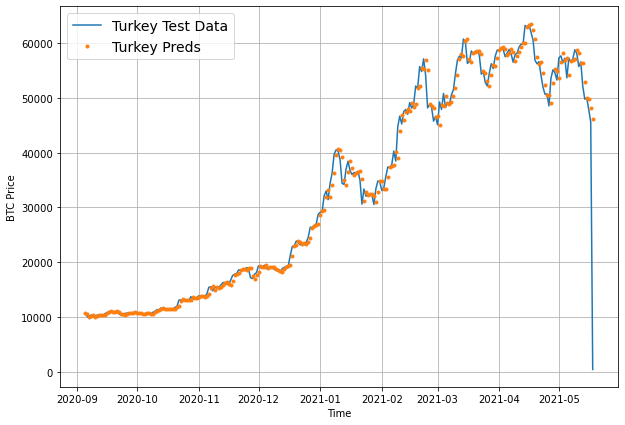

In [219]:
plt.figure(figsize=(10, 7))
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format="-",
                 label="Turkey Test Data", start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label="Turkey Preds",
                 start=offset);


## Compare Models

In [220]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)(
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T

model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,567.980225,1.147547e+06,1071.236206,2.516525,0.999570
model_1_dense_w7_h1,568.549866,1.172588e+06,1082.861084,2.549229,0.998785
model_2_dense_w30_h1,608.848145,1.284315e+06,1133.276001,2.768067,1.064273
model_3_dense_w30_h7,1234.244751,5.375468e+06,1418.801880,5.536006,2.196269
model_4_CONV1D,569.032715,1.169842e+06,1081.592163,2.551526,0.999633
model_5_LSTM,591.634094,1.254266e+06,1119.940063,2.652754,1.039337
model_6_multivariate,568.335510,1.164860e+06,1079.286865,2.549314,0.998408
model_8_NBEATs,579.216431,1.151404e+06,1073.034668,2.693565,1.017523
model_9_ensemble,566.653198,1.149247e+06,1072.029175,2.576328,0.995453
model_10_turkey,17136.683594,6.149394e+08,23728.250000,121.466049,26.519075


In [221]:
model_results["mae"]

naive_model               567.980225
model_1_dense_w7_h1       568.549866
model_2_dense_w30_h1      608.848145
model_3_dense_w30_h7     1234.244751
model_4_CONV1D            569.032715
model_5_LSTM              591.634094
model_6_multivariate      568.335510
model_8_NBEATs            579.216431
model_9_ensemble          566.653198
model_10_turkey         17136.683594
Name: mae, dtype: float64

In [222]:
model_results[["mae"]]

,mae
naive_model,567.980225
model_1_dense_w7_h1,568.549866
model_2_dense_w30_h1,608.848145
model_3_dense_w30_h7,1234.244751
model_4_CONV1D,569.032715
model_5_LSTM,591.634094
model_6_multivariate,568.335510
model_8_NBEATs,579.216431
model_9_ensemble,566.653198
model_10_turkey,17136.683594


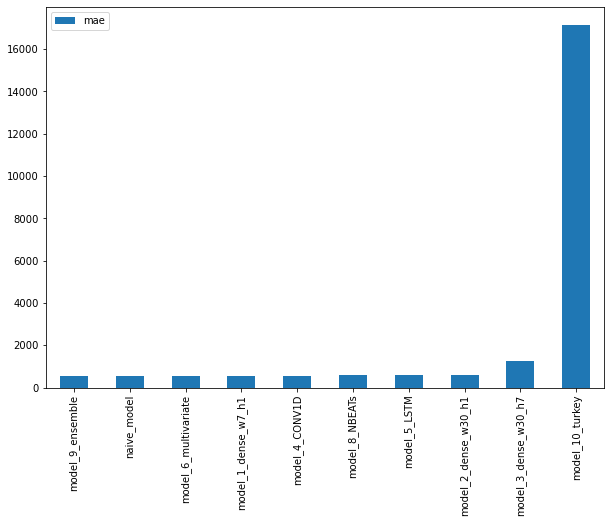

In [223]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");